$\textbf{Intro}$

In this work we are going to build a regression-based momentum alpha factor.

The term regression-based momentum alpha factor refers to a kind of alpha factor that combine linear regressions and simple returns. That means, a first alpha factor is constructed as a simple stock returns within a considered time window; the main time winow. In addition to that alpha factor, a second alpha factor is systematically constructed as the slop of a linear regression model built from a smaller sub time window of the main time window.

The smaller time window covers periods ranging from a certain time point within the main time window until the upper bound of the latter. In this way, we believe that combining the slop and the returns yield strong information on stock price's futur direction. For instance, if the slop is strongly positive and the return is strongly positive, then we hope to see a strong upward trend and vice versa. Hence, long and short positions will be taken accordingly. More details on the strategy will be shown later. 

The trading strategy will be evaluated using metrics that include, expected forward returns, annualized Sharpe Ratio, information coefficient, Turnover, etc.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import alphalens as al
from sklearn.linear_model import LinearRegression
from alphalens.plotting import*
from alphalens.tears import*

In [6]:
idx = pd.IndexSlice

We will first select the universe of stocks by selecting a portfolio of the 10 most traded stocks over the 10 years which have at least 8 years of trading data. We need the most traded stocks because we are aiming to minimise the liquitiy issue that can be a real world constraint against trading strategies.

For that, we build a helper function to construct a universe of that assets that fit the above requirements.

In [11]:
# build a function to construct a  universe of assets and their historical trading data

def select_and_process_historical_data(filename, traded_year=8, number_stocks=10):
    '''
    filename: is the csv file name that contains the historical 
                trading data to be processed and used to construct the portfolio
                
    '''
    data = pd.read_csv(filename, index_col=[0,1], parse_dates=True)
    
    # filter the dataframe by selecting the adjencent prices and select 10 years of trading data
    data = data.filter(like='adj_').rename(columns=lambda x: x.replace('adj_', '')).loc[idx[:, '2006':'2016'], :].dropna()
    
    # select the assets: we select the 10 most traded assets over the 10 years with at least 8 years of data
    dv = data.close.mul(data.volume)
    dv = dv.unstack('ticker').dropna(thresh=traded_year*252, axis=1).rank(axis=1, ascending=True).mean().nlargest(number_stocks)
    selected_assets = dv.index.tolist()
    universe = data.loc[idx[selected_assets, :], :]
    
    # remove data outlier by removing returns that are at least 100 per cent
    universe = universe[universe.close.pct_change().between(-1, 1)]
    
    
    return universe

In [13]:
universe = select_and_process_historical_data('HISTORIC_PRICES.csv', 8, 10)
universe

open       high        low      close       volume
ticker date                                                               
AAPL   2006-01-04   9.655252   9.764489   9.574288   9.634690  154900900.0
       2006-01-05   9.616698   9.625694   9.477903   9.558867  112355600.0
       2006-01-06   9.669389   9.857019   9.580714   9.805613  176114400.0
       2006-01-09   9.860874   9.921276   9.733646   9.773485  168760200.0
       2006-01-10   9.799188  10.524006   9.745212  10.391637  569967300.0
...                      ...        ...        ...        ...          ...
CSCO   2016-12-23  29.484966  29.542893  29.349802  29.475311    9167598.0
       2016-12-27  29.581511  29.755293  29.542893  29.620129   14175488.0
       2016-12-28  29.639438  29.707020  29.301529  29.369111   12022231.0
       2016-12-29  29.320838  29.494620  29.282220  29.407729   10995584.0
       2016-12-30  29.504275  29.542893  29.089130  29.176020   20190029.0

[27688 rows x 5 columns]

In [18]:
selected_assets = universe.index.unique('ticker').to_list()
selected_assets   

['AAPL', 'GOOGL', 'MSFT', 'BAC', 'XOM', 'C', 'JPM', 'GE', 'INTC', 'CSCO']

In [19]:
universe.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 27688 entries, ('AAPL', Timestamp('2006-01-04 00:00:00')) to ('CSCO', Timestamp('2016-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    27688 non-null  float64
 1   high    27688 non-null  float64
 2   low     27688 non-null  float64
 3   close   27688 non-null  float64
 4   volume  27688 non-null  float64
dtypes: float64(5)
memory usage: 1.9+ MB


# Build and evaluate alpha factors performance

### Alpha factor: regression-based momentum alpha

The idea is to calculate the coefficients of a linear regression within a time window and focus on the slop of such a linear regression model. The dependent variable of the linear regression is the stock prices, while the independent variable will be the time. 

The sign of the slop coefficient combined with the return  calculated separately on a wider time window will determine the nature of the trading position that well be taken. Within the time window considered, a positive slop is an increansing line or upward trend while a negative is a decreasing line or a downward trend of the stock price. 

For instance, let $y$ be the time series of a stock price representing the dependent variable of the linear regression model. Let, $x$ be the time vector, representing the independent variable of the linear regression model.

We are seeking  the alpha values $\alpha$ as slops such that $$y = \alpha x + b$$.

Moreover, the previously calculated alpha will be combined with a momentum alpha factor that is a result of simply calculating the returns of the main time window considered.

Indeed, the alpha value will be primarily combined with the 5-day returns alpha values.
For example let $\alpha_m$ denotes the return alpha value calculated in a 5-day time window. Let $\alpha$ be the slop of the regression within the last 3-day in the 5-day window. Denote $\bar{\alpha}$ be the alpha factor of the underlying strategy. Therefore,

if $\alpha_m < 0$ and $\alpha < 0$, we have $$\bar{\alpha} = \alpha_m + \alpha \,\,\,\,\, $$

Hence, 

If $\alpha_m > 0$ and $\alpha > 0$, then $\bar{\alpha} > 0$, we take a $\textbf{long position}.$

If $\alpha_m < 0$ and $\alpha < 0$, then $\bar{\alpha} < 0$, we take a $\textbf{short position}$

#### construction:
##### regression alpha factor

To build the alpha, we fit a regression model with independent variables being the time perionds (days) that covers periods ranging from a certain time point within the main time window to the upper bound of the latter. For example, we will pick the 3 last days of the whole 5 days. The idea is that the clop of the regression yield trend information on the last days, which may either enforce the 5-day return in case of similar sign or neutralize in case of different signs

5-day time interval may be equivalent to a trading week. 



In [14]:
price_df= universe.close.unstack('ticker').dropna()
price_df.head(6)

ticker,AAPL,GOOGL,MSFT,BAC,XOM,C,JPM,GE,INTC,CSCO
date,,,,,,,,,,
2006-01-04,9.634690,223.309335,20.452419,36.857078,42.736042,407.547758,29.572932,23.323910,17.966813,14.750795
2006-01-05,9.558867,226.318624,20.467586,36.904554,42.524441,409.569491,29.662501,23.264478,18.216519,15.163982
2006-01-06,9.805613,233.550949,20.406919,36.849165,43.363547,409.569491,29.871497,23.422964,18.244256,15.511060
2006-01-09,9.773485,234.172919,20.369002,36.872903,43.341657,407.631996,30.356667,23.363532,18.355206,15.750708
2006-01-10,10.391637,235.607297,20.475169,36.564310,43.677300,408.895580,30.401452,23.238064,18.112434,15.676335
2006-01-11,10.782319,236.545192,20.695088,36.477271,43.976459,412.602091,30.379059,23.396550,18.126372,16.031676


In [21]:
def regression_based_momentum_alpha(df, num_days=3, total_days=5):
    
    sub_window_data = df.iloc[num_days:].dropna()
    X = np.arange(num_days).reshape(-1, 1) + 1
    
    list_alphas_df = []
    
    for ticker in selected_assets:
        alphas = []
        data_for_reg = sub_window_data[ticker]
        N = len(data_for_reg)
        list_dates = []
        
        for i in range(N - num_days):
            y = data_for_reg[i:i+num_days].values
            list_dates.append(data_for_reg[i:i+num_days].index[-1])
            model = LinearRegression()
            model.fit(X, y)
            alpha_ = model.coef_[0]
            alphas.append(alpha_)
            
        df_alphas = pd.DataFrame(alphas, index=list_dates, columns=[ticker])
        df_alphas.index.name = 'date'
        list_alphas_df.append(df_alphas)
        
    all_alpha_values_df = pd.concat(list_alphas_df, axis=1)
    
    return all_alpha_values_df
        

In [23]:
# now we construct the DataFrame of the alphas for each ticker, each date.
regression_alpha = regression_based_momentum_alpha(price_df)
regression_alpha = regression_alpha.dropna(axis=0)
regression_alpha.columns.name = 'ticker'
regression_alpha

ticker,AAPL,GOOGL,MSFT,BAC,XOM,C,JPM,GE,INTC,CSCO
date,,,,,,,,,,
2006-01-11,0.504417,1.186136,0.163043,-0.197816,0.317401,2.485047,0.011196,0.016509,-0.114417,0.140484
2006-01-12,0.220466,-1.537245,0.053084,-0.162209,-0.080262,2.063853,-0.291102,-0.062734,-0.051973,0.095033
2006-01-13,0.108588,-1.349165,-0.037917,-0.118690,0.255380,-0.252717,-0.291102,-0.108959,-0.121351,-0.198330
2006-01-17,0.026930,0.872694,-0.056875,-0.193860,0.693175,-2.527167,-0.089570,-0.019811,-0.156023,-0.214858
2006-01-18,-0.199184,-5.351545,-0.136501,-0.213641,0.043779,-2.274450,-0.212728,-0.102356,-1.106374,-0.078464
...,...,...,...,...,...,...,...,...,...,...
2016-12-22,-0.325924,-2.760000,0.004891,-0.084046,0.211957,-0.152762,0.176022,-0.091850,-0.135379,-0.048273
2016-12-23,-0.266665,-2.200000,-0.146738,-0.014832,0.207140,0.118268,0.146685,-0.004615,-0.004835,0.053100
2016-12-27,0.479010,0.125000,-0.132064,0.034607,-0.057807,0.295669,0.117348,0.038966,0.067689,0.106200


In [24]:
# Before building the regression-based momentum alpha factor, we first quickly compute the momentum factor which 
# are simply the 5-day returns

momentum_5day_alpha = price_df.pct_change(5).dropna()
momentum_5day_alpha

ticker,AAPL,GOOGL,MSFT,BAC,XOM,C,JPM,GE,INTC,CSCO
date,,,,,,,,,,
2006-01-11,0.119114,0.059271,0.011865,-0.010305,0.029025,0.012402,0.027259,0.003114,0.008881,0.086835
2006-01-12,0.133248,0.027458,0.005558,-0.018010,0.023336,0.008433,0.005284,-0.006529,-0.011420,0.046322
2006-01-13,0.121755,0.001267,0.010405,-0.016534,0.025913,0.006170,-0.002499,-0.010431,-0.019764,0.007991
2006-01-17,0.113874,0.000450,0.004840,-0.027682,0.036027,0.000827,-0.023605,-0.012436,-0.035890,-0.019937
2006-01-18,0.020160,-0.052900,-0.006296,-0.020558,0.020548,-0.003296,-0.033882,-0.011367,-0.134798,-0.012646
...,...,...,...,...,...,...,...,...,...,...
2016-12-23,0.004743,-0.002519,0.015088,-0.002648,-0.005155,0.020753,0.024841,0.011668,0.018177,-0.001961
2016-12-27,0.005316,-0.003163,-0.005344,0.005783,0.003650,0.023969,0.019899,0.006911,0.004879,-0.002276
2016-12-28,-0.001625,-0.013040,-0.008656,-0.016733,-0.001438,-0.012500,-0.000347,-0.009640,-0.015587,-0.004581


Now we can build the regression-based momentum alpha. 
it is simply the addtion of the two alpha factors already calculated as explained by the previous mathematical formula.

In [25]:
reg_momentum_alpha = regression_alpha + momentum_5day_alpha
reg_momentum_alpha.dropna(axis=0, inplace=True)
reg_momentum_alpha

ticker,AAPL,GOOGL,MSFT,BAC,XOM,C,JPM,GE,INTC,CSCO
date,,,,,,,,,,
2006-01-11,0.623532,1.245408,0.174908,-0.208121,0.346426,2.497449,0.038455,0.019623,-0.105536,0.227318
2006-01-12,0.353714,-1.509788,0.058641,-0.180219,-0.056927,2.072286,-0.285817,-0.069263,-0.063393,0.141355
2006-01-13,0.230343,-1.347898,-0.027512,-0.135224,0.281293,-0.246546,-0.293600,-0.119391,-0.141115,-0.190339
2006-01-17,0.140804,0.873143,-0.052036,-0.221542,0.729202,-2.526340,-0.113174,-0.032247,-0.191912,-0.234795
2006-01-18,-0.179024,-5.404444,-0.142797,-0.234200,0.064327,-2.277746,-0.246610,-0.113723,-1.241172,-0.091111
...,...,...,...,...,...,...,...,...,...,...
2016-12-22,-0.321866,-2.767319,0.020391,-0.110816,0.211737,-0.148445,0.186371,-0.066259,-0.131574,-0.053823
2016-12-23,-0.261922,-2.202519,-0.131650,-0.017479,0.201985,0.139021,0.171526,0.007052,0.013342,0.051139
2016-12-27,0.484325,0.121837,-0.137409,0.040390,-0.054157,0.319638,0.137248,0.045877,0.072569,0.103924


In [26]:
alpha_factors = reg_momentum_alpha.stack('ticker')
alpha_factors

date        ticker
2006-01-11  AAPL      0.623532
            GOOGL     1.245408
            MSFT      0.174908
            BAC      -0.208121
            XOM       0.346426
                        ...   
2016-12-29  C        -0.865208
            JPM      -0.616213
            GE       -0.098171
            INTC     -0.206887
            CSCO     -0.104885
Length: 27620, dtype: float64

#### preprocessing the alpha factor:

$\textbf{Market neutral}$: We substract the mean from each alpha value in the vector so that its values sum to zero. This implies that general market movements that affect all stocks are cancelled out. Note that it is also possible to neutralize the portfolio by sector, but that is out of scope here.


$\textbf{Ranking}$: This consists of transforming alpha signals to be less sensitive to noise and outliers, and to avoid excessive trades that may impact transaction costs. 

In [27]:
# demean alpha factor
def market_neutral(alpha_factor):
    data = alpha_factor.copy()
    demeaned_alpha = data - data.groupby('date').transform('mean')
    
    return demeaned_alpha

# rank alpha factor
def rank_alpha(alpha_factor):
    
    return alpha_factor.unstack('ticker').rank(axis=1, ascending=True).stack('ticker')

In [28]:
market_neutralized_alpha = market_neutral(alpha_factors)
market_neutralized_alpha

date        ticker
2006-01-11  AAPL      0.137585
            GOOGL     0.759462
            MSFT     -0.311038
            BAC      -0.694067
            XOM      -0.139520
                        ...   
2016-12-29  C        -0.224242
            JPM       0.024752
            GE        0.542794
            INTC      0.434078
            CSCO      0.536080
Length: 27620, dtype: float64

In [29]:
ranked_reg_momentum_alpha = rank_alpha(market_neutralized_alpha)
ranked_reg_momentum_alpha                                       

date        ticker
2006-01-11  AAPL       8.0
            GOOGL      9.0
            MSFT       5.0
            BAC        1.0
            XOM        7.0
                      ... 
2016-12-29  C          2.0
            JPM        3.0
            GE        10.0
            INTC       6.0
            CSCO       9.0
Length: 27620, dtype: float64

### Evaluate alpha factors: alphalens 

We evaluate the alpha factor strategy on different holding periods with the alphalens .

This evaluation phase is actually the moment we can be convinced or not if the the underlying alpha factor is worth being considered for further investigations. 

In [30]:
closing_prices = universe.close.unstack('ticker')
closing_prices

ticker,AAPL,GOOGL,MSFT,BAC,XOM,C,JPM,GE,INTC,CSCO
date,,,,,,,,,,
2006-01-04,9.634690,223.309335,20.452419,36.857078,42.736042,407.547758,29.572932,23.323910,17.966813,14.750795
2006-01-05,9.558867,226.318624,20.467586,36.904554,42.524441,409.569491,29.662501,23.264478,18.216519,15.163982
2006-01-06,9.805613,233.550949,20.406919,36.849165,43.363547,409.569491,29.871497,23.422964,18.244256,15.511060
2006-01-09,9.773485,234.172919,20.369002,36.872903,43.341657,407.631996,30.356667,23.363532,18.355206,15.750708
2006-01-10,10.391637,235.607297,20.475169,36.564310,43.677300,408.895580,30.401452,23.238064,18.112434,15.676335
...,...,...,...,...,...,...,...,...,...,...
2016-12-27,115.811668,809.930000,61.903920,22.356110,87.432359,60.208026,85.204605,31.075043,35.846409,29.620129
2016-12-28,115.317843,804.570000,61.620226,22.079254,86.998810,59.173185,84.588527,30.880215,35.420932,29.369111
2016-12-29,115.288214,802.880000,61.532183,21.752960,87.046983,58.522714,83.992006,30.889956,35.449942,29.407729


####  alphalens processed data

In the following, we build a DataFrame that combine the ranked alpha factors, the chosen holding periods and their corresping returns (the forward returns), and quantiles to classify the factors into different quintiles and follow their predicatbility for each holding period considered. 

In [31]:
HOLDINGS = (1, 2, 3, 4)
quantiles = 5
alphalens_data = al.utils.get_clean_factor_and_forward_returns(factor=ranked_reg_momentum_alpha,
                                                              prices=closing_prices,
                                                              periods=HOLDINGS,
                                                              quantiles=quantiles)

Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [32]:
alphalens_data

1D        2D        3D        4D  factor  \
date       asset                                                   
2006-01-11 AAPL   0.004660  0.020142  0.009656 -0.016805     8.0   
           GOOGL -0.016962 -0.011407 -0.009584 -0.056655     9.0   
           MSFT  -0.005497 -0.003664 -0.010993 -0.016856     5.0   
           BAC   -0.006508 -0.006508 -0.017137 -0.018221     1.0   
           XOM   -0.010453  0.011614  0.021072  0.013605     7.0   
...                    ...       ...       ...       ...     ...   
2016-12-27 C     -0.017188 -0.027991 -0.027173 -0.027173     9.0   
           JPM   -0.007231 -0.014232 -0.009641 -0.650921     8.0   
           GE    -0.006270 -0.005956 -0.009404 -0.248370     4.0   
           INTC  -0.011869 -0.011060 -0.021581 -0.505359     5.0   
           CSCO  -0.008475 -0.007171 -0.014993 -0.513161     6.0   

                  factor_quantile  
date       asset                   
2006-01-11 AAPL                 4  
           GOOGL                5  
           MSFT                 3  
           BAC                  1  
           XOM                  4  
...                           ...  
2016-12-27 C                    5  
           JPM                  4  
           GE                   2  
           INTC                 3  
           CSCO                 3  

[27600 rows x 6 columns]

#### factor forward returns

In [33]:
factor_returns = al.performance.factor_returns(alphalens_data)
factor_returns

,1D,2D,3D,4D
date,,,,
2006-01-11,0.001953,0.005599,0.007592,0.014687
2006-01-12,-0.000093,-0.002900,0.005482,0.005102
2006-01-13,0.001397,0.007612,0.008049,0.020002
2006-01-17,-0.005606,-0.011720,-0.018063,-0.001218
2006-01-18,0.008720,0.022472,0.011188,0.004369
...,...,...,...,...
2016-12-20,0.001302,-0.000205,-0.000716,-0.000730
2016-12-21,-0.001615,0.000590,0.000274,-0.001031
2016-12-22,-0.001175,-0.002297,-0.000805,0.000002


#### sharpe ratio

The ratio of reward to volatility. It is a metric used in trading to measure the performance (mean return) of our portfolio relative to its risk (volatility) on the considered holding periods. 

In [34]:
sharpe_ratio = np.sqrt(252)*factor_returns.mean().div(factor_returns.std()).to_frame().rename(columns={0:'sharpe ratio'})
sharpe_ratio.index.name = 'days'
sharpe_ratio

,sharpe ratio
days,
1D,0.584523
2D,0.324932
3D,0.056509
4D,-0.099312


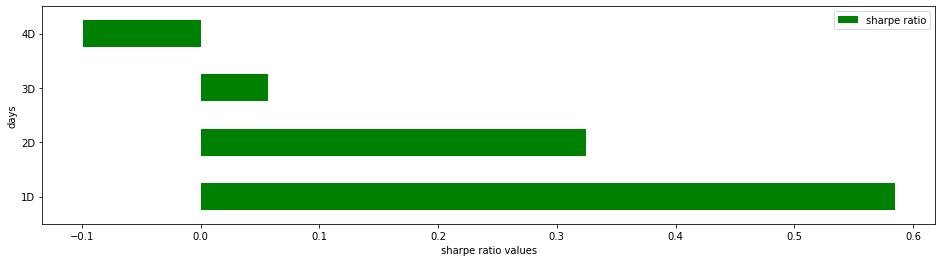

In [35]:
sharpe_ratio.plot.barh(color='g', figsize=(16, 4));
plt.xlabel('sharpe ratio values');

The 1-Day holding period provides the best Sharpe ratio, $SR = 0.58$. This is already a hint to consider a one day holding period for this strategy. It actually make sense as end of week bullish tend to attract market particpants to place a long postion and cash out the first trading day of the week after. Likewise, end week bearish market trigger a selling instinct making market participants to short their holdings in the next week's first trading day.

#### quantile analysis

In [36]:
mean_ret_quantile, mean_std_quantile = al.performance.mean_return_by_quantile(alphalens_data)
mean_ret_quantile

,1D,2D,3D,4D
factor_quantile,,,,
1,-0.000293,-0.000376,-0.000298,-0.000569
2,-0.000341,-0.000122,-0.000095,0.000396
3,0.000154,0.000126,0.000300,0.000485
4,0.000227,0.000295,0.000401,0.000482
5,0.000253,0.000077,-0.000308,-0.000794


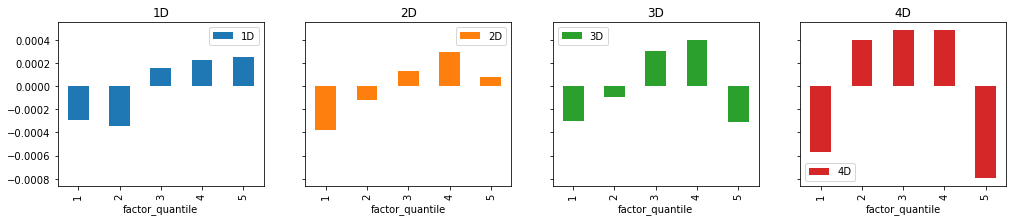

In [37]:
mean_ret_quantile.plot.bar(subplots=True,
                          layout=(1, 4),
                          figsize=(17, 3),
                          sharey=True);

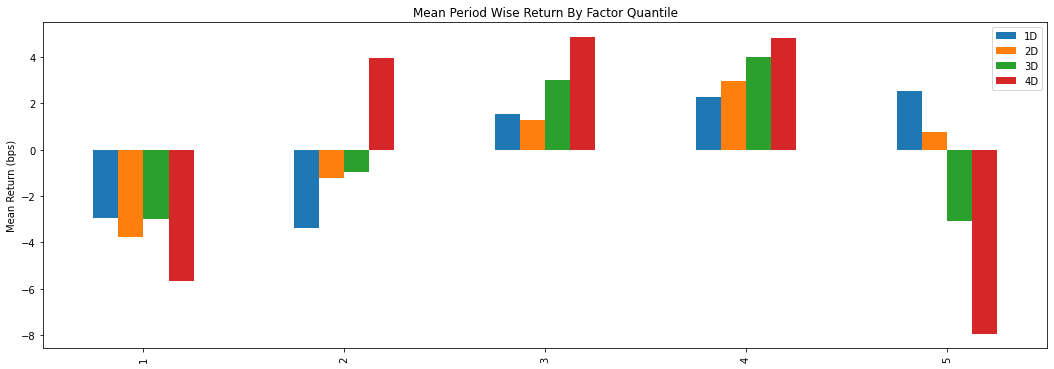

In [38]:
plot_quantile_returns_bar(mean_ret_quantile);

Regarding the quantile-wise factor returns, we can see that on the one-day holding period, the first two quantiles show the lowest and negative mean returns, while the last thre quantile increasingly show higher mean returns.

looking at the on-day holding period, we see the pattern of mean returns accross quantiles exhibit a transitionfrom neagtive to positive mean return going from lowest quantile to highest quantile.  

With the 1D holding period, we can observe that this strategy has effectively differentiated the better-performing and worse-performing stocks

$\textbf{Strategy Evaluation:}$ This pattern of mean returns suggest that for the 1D holding period our strategy is successful in ranking stocks according to their performance. Stocks predicted to perform well (in higher quantiles) indeed yield higher returns, and those predicted to perform poorly (lower quantiles) yield lower or negative returns.

$\textbf{Advice:}$ With 1D holding period, one might consider focussing on stocks in the highest and lowest quantiles for investing with the underlying strategy. 

However, since the only results we have so far come from past data, we will need to continue the investigation and evaluate further performance metrics.

#### cumulative returns

We want to see the investment performance within each quintile over time.

For that, we first compute the daily mean returns by quantile as opposed to the previous average returns by quantile. Then we visualize the evolution of cumulative returns in each quintile.

How it works:

$$\text{CumulativeReturn at time} \,\,\,T  = \prod_{t=1}^{T}(1 + \text{dailyreturn_t}) - 1$$

Then the changes of these cumulative returns for each quantile for each hodling period will be plotted

In [39]:
mean_ret_quantile_daily, mean_std_quantile_daily = al.performance.mean_return_by_quantile(alphalens_data, by_date=True)
mean_ret_quantile_daily

1D        2D        3D        4D
factor_quantile date                                              
1               2006-01-11  0.001606 -0.004183 -0.008707 -0.044001
                2006-01-12  0.000095  0.004375 -0.002778 -0.009544
                2006-01-13  0.004305 -0.002728 -0.009516 -0.028506
                2006-01-17  0.022249  0.031433  0.028059  0.016178
                2006-01-18 -0.007788 -0.038223 -0.009379  0.007435
...                              ...       ...       ...       ...
5               2016-12-20  0.001500  0.001945  0.000620  0.000264
                2016-12-21 -0.000148  0.003790  0.002945 -0.000922
                2016-12-22 -0.001065 -0.002519 -0.000200 -0.000101
                2016-12-23 -0.001451  0.000851  0.000944  0.007321
                2016-12-27 -0.002342 -0.004553 -0.003464  0.300740

[13800 rows x 4 columns]

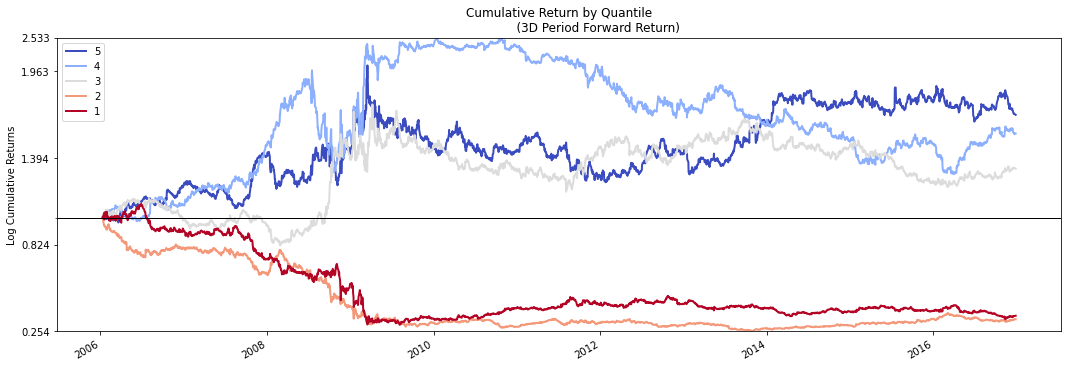

In [40]:
plot_cumulative_returns_by_quantile(mean_ret_quantile_daily['1D'], period='3D');

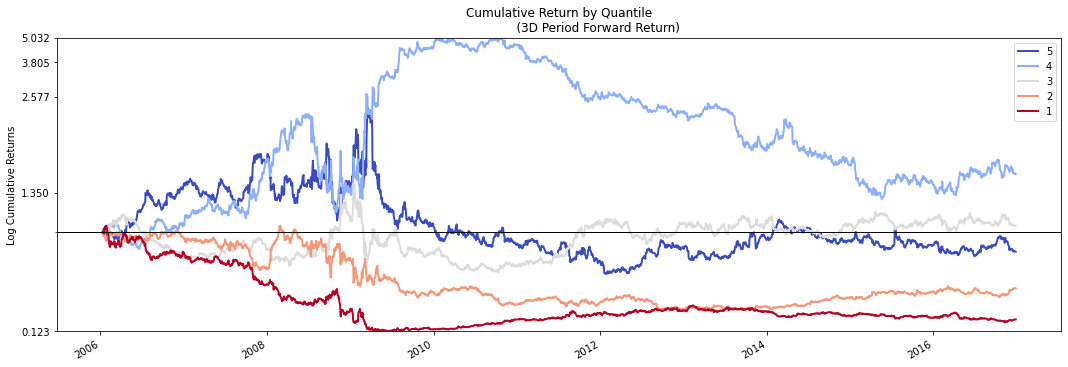

In [41]:
plot_cumulative_returns_by_quantile(mean_ret_quantile_daily['2D'], period='3D');

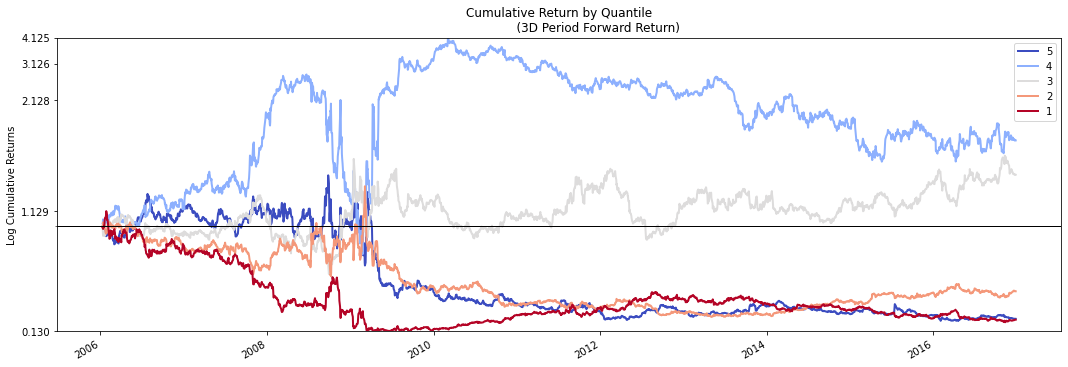

In [42]:
plot_cumulative_returns_by_quantile(mean_ret_quantile_daily['3D'], period='3D');

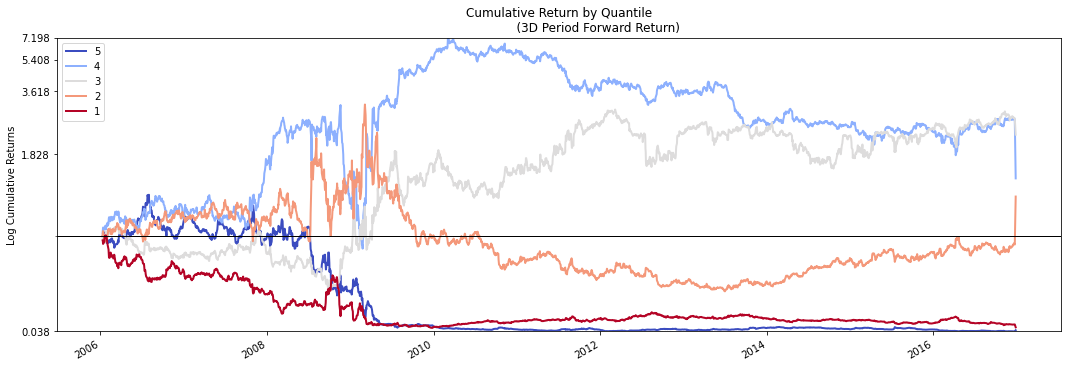

In [43]:
plot_cumulative_returns_by_quantile(mean_ret_quantile_daily['4D'], period='3D');

The visualisations of the investment growth show that one-day holding period yields is a relatively good investment plan compared to other holding periods. High return stocks yield higest positive cumulative returns and low returns provide lowest negative returns. Any other holding period has shown the same behavior, which motivates us to favor the one-day holding period plan. That means shorting and longing stocks according to the strategy and hold for one day period is the best investment we can do on this portfolio with this strategy.

Indeed, the cumulative return plots have shown that, with one-day holding periods, stocks in the highest quantile (those predicted to perform the best) show highest positive cumulative returns over time, which would indicate that the factor used to sort the stocks is effectively predictive.
The same occurs for the stocks in the lowest quantile(those that are being shorted).  They show lowest negative cumulative returns over time.  

Conclusion, theregression-based momentum  alpha factor is predictivefor one-day holding period.


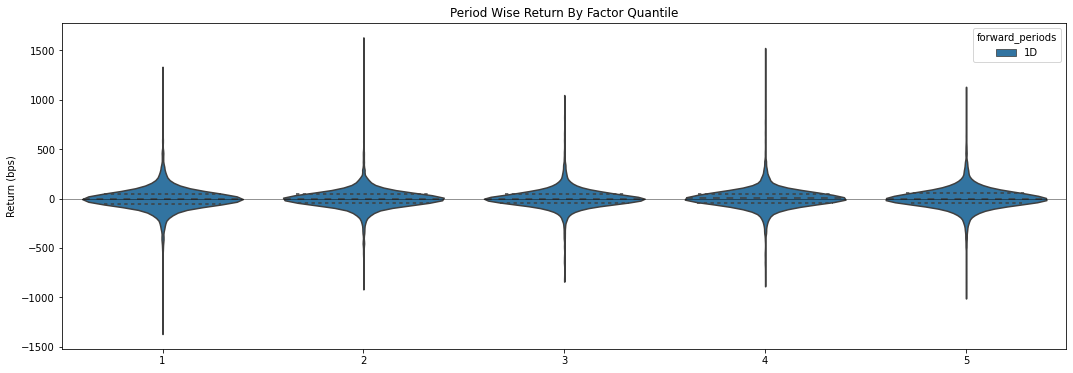

In [44]:
plot_quantile_returns_violin(mean_ret_quantile_daily['1D'].to_frame());

#### Information Coefficient (IC) 

We now evaluate the predictabibility of our alpha factor in different holding periods and denote the information coefficient (IC).  The IC tells us wether the alpha values are correlated with the future returns. In practice, we calculate it using the rank correlation by considering both the rank of the alpha values and the rank of the futur returs. 
Note that, in general, we use the ranks to avoid the influence of outliers on calculations, but here, most importantly because we do not care to be wrong in the right direction. 

Correlation of rank values is called Spearman rank correlation to be distinguished from the Pearson correlation. It is given by
$$\mathrm{rankCorr}(X, Y) = \frac{\mathrm{cov}(rank(X), rank(Y))}{\mathrm{std}(rank(X))\times \mathrm{std}(rank(Y))}$$

The analysis made so far suggests high predictability for the one-day holding period,  and low predictability for the the rest. 

In [45]:
ic = al.performance.factor_information_coefficient(alphalens_data)
ic

,1D,2D,3D,4D
date,,,,
2006-01-11,0.200000,0.393939,0.551515,0.406061
2006-01-12,-0.151515,-0.260606,0.090909,0.127273
2006-01-13,0.078788,0.381818,0.381818,0.393939
2006-01-17,-0.624242,-0.224242,-0.187879,-0.054545
2006-01-18,0.721212,0.721212,0.442424,0.236364
...,...,...,...,...
2016-12-20,0.442424,-0.054545,-0.127273,-0.127273
2016-12-21,-0.357576,0.115152,0.078788,-0.248485
2016-12-22,-0.248485,-0.490909,0.018182,-0.030303


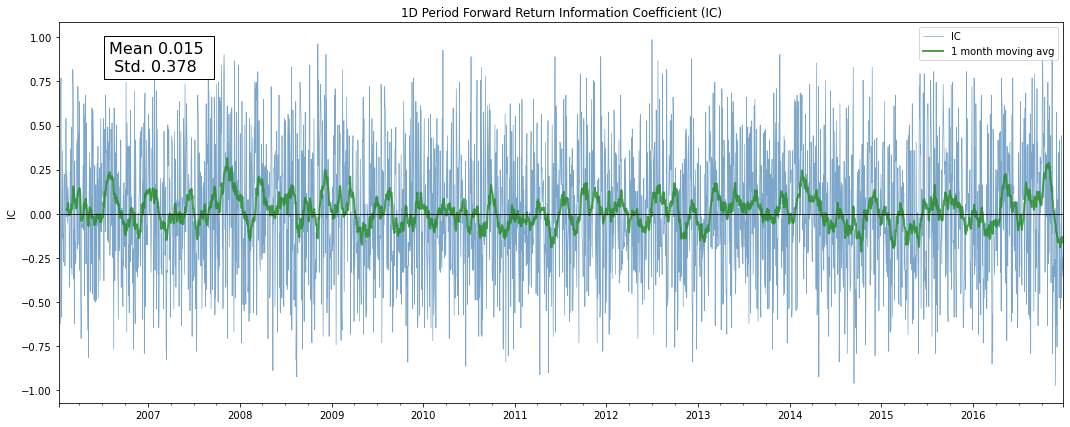

In [46]:
plot_ic_ts(ic[['1D']]);

We observe a relatively positive moving average of the IC for the one-day holding period. 

The mean IC is positive as well, which is good.  

We also want to check the yearly information coefficient, or the annual mean information coefficient

In [47]:
ic_by_year = ic.resample('A').mean()
ic_by_year.index = ic_by_year.index.year
ic_by_year

,1D,2D,3D,4D
date,,,,
2006,0.027829,0.035533,0.030451,0.018479
2007,0.050441,0.056381,0.041264,0.019389
2008,0.038256,0.030782,0.032603,0.039933
2009,0.004254,0.002213,-0.003679,-0.002165
2010,-0.017056,-0.019721,-0.031401,-0.024435
2011,0.002047,-0.043004,-0.028427,-0.026312
2012,0.006015,-0.013391,-0.010521,0.005430
2013,0.030545,0.007338,0.014286,0.010726
2014,0.009584,-0.003078,-0.026407,-0.018663


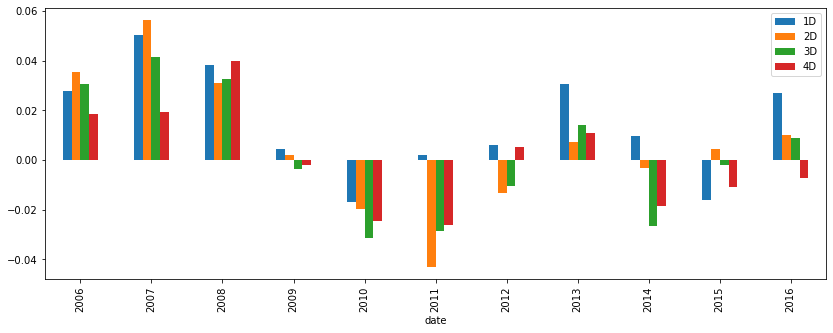

In [48]:
ic_by_year.plot.bar(figsize=(14, 5));

#### factor rank autocorrelation (FRA)

The Factor rank autocorrelation is another way to measure turnover.  The latter measures what fraction of the portfolio's total value gets traded in a time period. Turnover is a useful proxy for measuring real-world trading constraints that are liquidy and transaction costs. Indeed, liquidity and transaction costs are dependent upon market conditions at the time of a trade. That is why it is difficult to simulate actual transaction costs when evaluating an alpha factor. Therefore turnover is used to measure these real-world constraints. Since we are in the at the alpha research stage, turnover can be defined in terms of changes in portfolio weights. It is then easier to use directly the ranked alpha vectors and calcualte the FRA as an alternative to the turnover. 

To calculate the FRA for a single time period, we get the ranked alpha vector for the previous day ($t-1$) and also the ranked alpha vector for the current day $(t-1)$. Then we calculate the Spearman rank correlation between the prio days and current days ranked alpha vectors. 
We repeat this for multiple days so that we have a time series of factor rank autocorrelations.

The FRA is close to one when the rank of stocks given by the values does not change much.
When the rank of stocks don't change much from day to day, this also means that the weights of our theoretical portfolio don't change much either, which means less trading  and therefore less turnover.


In [49]:
fra = al.performance.factor_rank_autocorrelation(alphalens_data, period=1)
fra.dropna(inplace=True)
fra

date
2006-01-12    0.442424
2006-01-13    0.393939
2006-01-17    0.309091
2006-01-18    0.127273
2006-01-19    0.903030
                ...   
2016-12-20   -0.175758
2016-12-21    0.321212
2016-12-22   -0.078788
2016-12-23    0.660606
2016-12-27   -0.054545
Freq: C, Name: 1, Length: 2759, dtype: float64

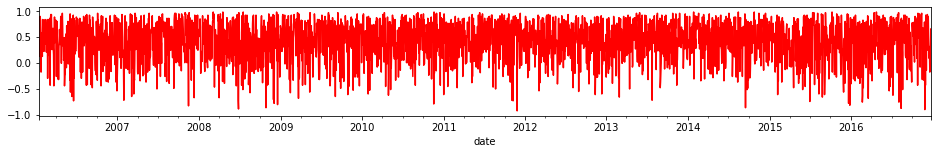

In [50]:
fra.plot(color='r', figsize=(16, 2));


In [51]:
fra.mean()

0.41792261139850884

The FRA is mostly positive but still relatively far from one. That means, more trading and potentially high transaction costs. We see that even though our alpha factor is relatively predictive regarding the information coefficient, it will incure some transaction costs. Hence a trade-off situation between predictive alpha and transation cost arise. 

### Summary Statistics

Now we release a summary statistics of the alpha factors

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,1.0,2.0,1.5,0.500045,5520,20.0
2,3.0,4.0,3.5,0.500045,5520,20.0
3,5.0,6.0,5.5,0.500045,5520,20.0
4,7.0,8.0,7.5,0.500045,5520,20.0
5,9.0,10.0,9.5,0.500045,5520,20.0


Returns Analysis


,1D,2D,3D,4D
Ann. alpha,0.092,0.041,0.014,0.002
beta,-0.092,-0.079,-0.081,-0.074
Mean Period Wise Return Top Quantile (bps),2.527,0.384,-1.028,-1.986
Mean Period Wise Return Bottom Quantile (bps),-2.933,-1.883,-0.992,-1.423
Mean Period Wise Spread (bps),5.459,2.298,0.013,-0.461


Information Analysis


,1D,2D,3D,4D
IC Mean,0.015,0.006,0.002,0.000
IC Std.,0.378,0.378,0.378,0.376
Risk-Adjusted IC,0.039,0.016,0.006,0.001
t-stat(IC),2.048,0.843,0.306,0.049
p-value(IC),0.041,0.399,0.759,0.961
IC Skew,0.028,0.028,0.034,0.051
IC Kurtosis,-0.629,-0.607,-0.620,-0.627


Turnover Analysis


,1D,2D,3D,4D
Quantile 1 Mean Turnover,0.536,0.719,0.720,0.730
Quantile 2 Mean Turnover,0.684,0.759,0.754,0.765
Quantile 3 Mean Turnover,0.709,0.747,0.753,0.747
Quantile 4 Mean Turnover,0.671,0.769,0.768,0.770
Quantile 5 Mean Turnover,0.514,0.703,0.707,0.714


,1D,2D,3D,4D
Mean Factor Rank Autocorrelation,0.418,0.042,0.032,0.019


<Figure size 432x288 with 0 Axes>

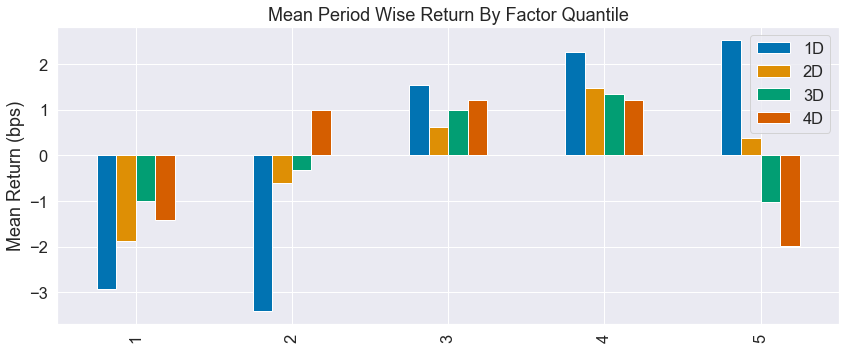

In [52]:
create_summary_tear_sheet(alphalens_data);

#### Returns Analysis:

Alphalens uses the S&P500 as a benchmark for comparing  our strategy's performance. 

$\text{Ann. alpha}$ measures our strategy's performance relative to the benchmark (say S&P500) for different holding periods, independant of the market's movements.

In the summary above, we can see that the higest $\text{Ann. alpha}$ is positive for all holding periods and the pic is  found on the one-day holding period with $0.092$. The $\text{Ann. alpha}$ then decreases monotically on other holding periods. Therefore, we can conclude that the strategy yield highest excess return when traded on one-day holding period. 


The $\beta$ of the portfolio is negative for all holding periods. This means that our portfolio's volatility is uncorrelated with the market volatility. This is a good thing for our momentum strategy as we are looking for stocks to go up even if the market goes down and vice versa.


Basic Formula: 

$\alpha = R_p - (R_f + \beta\times (R_m - R_f))\\$
Alpha ($\alpha$)  is a measure of the portfolio's performance on a risk-adjusted basis. It shows how much excess return the portfolio has generated compared to what would be expected based on its beta and the market return.

A positive alpha indicates that the portfolio has outperformed the market, given its level of risk (as measured by beta), while a negative alpha suggests underperformance.

The term $(R_f + \beta\times (R_m - R_f))$ represents the expected return of the portfolio based on its beta and the market's excess return over the risk-free rate. Subtracting this from the actual portfolio return ($R_p$) isolates the return attributable to the skill of the portfolio manager or the effectiveness of the investment strategy, independent of market movements.

$R_p = \text{Portfolio returns}$

$R_f = \text{Risk free rate}$

$R_m = \text{Benchmark (market) return}$

$\beta = \frac{\mathrm{Cov}(R_p, R_m)}{\mathrm{Var}(R_m)}=$  The beta of the portfolio measures the portfolio volatility compared to the benchmark market. 

A Beta of $1$ means the portfolio will move with the benchmark. 

A Beta less than $1$ means the portfolio is theoretically less volatile than the market, and vice versa.

#### Information Coefficient analysis:

IC Mean: The average value of the Information Coefficient (IC) over different periods. Recall that the IC measures the correlation between predicted and actual stock returns. Therefore, a positive IC indicates that the predictions made by our alpha factor are generally. In this case, the IC Mean is positive and monotonically decreasing across holding periods. 

The IC Mean is highest in the one-day holding period indicating that our alpha factor is more predictive for one-day hold period than for others. 


IC Std. (Standard Deviation): This shows the variability or dispersion of the IC values. A higher standard deviation implies more variability in the prediction accuracy. We can see that the IC standard deviation is almost constant over the different holding periods.

Risk-Adjusted IC: Adjusts the IC for the risk (standard deviation) involved. It's essentially the IC Mean divided by the IC Standard Deviation.  We can see that the Risk-Adjusted IC also increases over time, indicating better risk-adjusted predictive power for longer holding periods.

t-stat(IC): The t-statistic for the IC indicates whether the IC is statistically significantly different from zero. Higher absolute values suggest greater statistical significance, as we can observe for the one-day holding period.

p-value(IC): Represents the probability that the IC is different from zero purely by chance. A lower p-value (typically <0.05) suggests that the IC is statistically significant. A higher p-value suggests that we may be observing a non-zero IC just by chance or by some random fluctuations. 


The null hypothesis:

"The Information Coefficient (IC) has no predictive power."

This is interpreted as there is no correlation between the predicted returns from our alpha model and the actual returns.
Regarding the results, we can see that the t-statistic is strongly higher for one-day holding period than for the rest suggesting that the alpha factor is statistically most significant for one-day holding period. 

For a level of significance $\alpha=0.05$, the null hypothesis is rejected for one-day and two-day holding period. Therefore, we can argue that the the IC does have a predictive power for one-day holding period, and that is not by pure chance since it is statistically significant. 


IC Skew: Measures the asymmetry of the distribution of IC values. A skewness close to zero indicates a symmetrical distribution. Positive skew indicates a distribution with a longer tail on the right, while negative skew has a longer tail on the left. We have postive skewness for all holding periods. 

IC Kurtosis: Measures the 'tailedness' of the IC distribution. A negative kurtosis indicates a distribution that is flatter than a normal distribution (less extreme values). That is what we have oberved accross all holding periods. 


Conclusion
This analysis suggests that the regression-base momentum factor being studied has better predictive power and statistical significance when applied on one-day holding period.

#### Turnover Analysis
The data provides Turnover Analysis for different quantiles over the various holding periods (1D, 2D, 3D, 4D). Recall that the turnover refers to how frequently assets within a portfolio or quintiles are bought and sold. That means the proportions of assets that have left and/or joinded the quintile.

Increasing Turnover with Holding Period: 

For each quantile, the turnover tends to increase with the length of the holding period. This is a typical pattern, as holding assets for longer periods naturally leads to higher turnover rates.

Variation Across Quantiles: 

Different quantiles show different turnover behaviors. For example: Quantiles 1 and 5, which represent the extreme ends of the factor scoring, have lower turnover rates compared to the middle quantiles.
Quantiles 2, 3, and 4 exhibit higher turnover rates. This might indicate more frequent trading in these groups, possibly due to more significant price movements.

For the one-day holding period, we observe the smallest turnover. This looks good because this is our candidate for the strategy.   

##### Factor Rank Autocorrelation:

1D (1-Day) Factor Rank Autocorrelation (0.418): This suggests that the factor ranks are relatively consistent from one day to the next. 

2D, 3D, 4D Autocorrelations (0.042,	0.032,	0.019): As theholding perio increases (2 days, 3 days, 4 days), the Factor Rank Autocorrelation decreases. This implies that the factor ranks are less consistent over longer periods. The ranks of stocks based on this alpha factor are more likely to change over these extended time frames.